In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Load dataset
df = pd.read_csv("/kaggle/input/devanagari-character-set/data.csv")
label_encoder = LabelEncoder()
df['character'] = label_encoder.fit_transform(df['character'])

# Function to visualize images
def visualize(df, digit_num):
    raw_data = df.loc[digit_num]
    filtered_image = raw_data.iloc[:-1].values.reshape((32, 32))
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f'Label: {raw_data["character"]}')
    plt.axis('off')
    plt.show()

# Optimized SiameseDataset for GPU
class SiameseDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.labels = data['character'].values
        self.images = data.iloc[:, :-1].values.reshape(-1, 32, 32, 1) / 255.0
        self.images = torch.tensor(self.images, dtype=torch.float32).permute(0, 3, 1, 2)  # Shape (N, 1, 32, 32)
        
        # Create pairs and store them
        self.pairs, self.pair_labels, self.pair_indices = self.create_pairs()

    def create_pairs(self):
        pairs, labels, indices = [], [], []
        label_map = {label: np.where(self.labels == label)[0] for label in np.unique(self.labels)}
        
        for idx, label in enumerate(self.labels):
            # Positive pair
            pos_idx = np.random.choice(label_map[label])
            pairs.append((self.images[idx], self.images[pos_idx]))
            labels.append(1)  # Same class
            indices.append((idx, pos_idx))

            # Negative pair
            neg_label = np.random.choice([l for l in label_map.keys() if l != label])
            neg_idx = np.random.choice(label_map[neg_label])
            pairs.append((self.images[idx], self.images[neg_idx]))
            labels.append(0)  # Different class
            indices.append((idx, neg_idx))

        return pairs, labels, indices

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        img1, img2 = self.pairs[index]
        label = self.pair_labels[index]
        indices = self.pair_indices[index]
        return img1, img2, torch.tensor(label, dtype=torch.float32), indices


# Prepare the dataset and DataLoader
dataset = SiameseDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True)

# Define the Siamese Network architecture with Batch Normalization and Dropout
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5)  # Dropout layer to prevent overfitting
        )

    def forward_one(self, x):
        return self.cnn(x)

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Initialize the model and move it to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)

# Define the contrastive loss function with L1 norm
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate L1 distance
        euclidean_distance = torch.abs(output1 - output2)
        euclidean_distance = euclidean_distance.sum(dim=1)  # Sum over the feature dimensions

        # Contrastive loss formula
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

# Initialize the contrastive loss function
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with validation loss and regularization
epochs = 45
train_losses = []
val_losses = []

# Split the data into train and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, pin_memory=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for img1, img2, labels, _ in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{epochs}', unit='batch'):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()
        
        output1, output2 = model(img1, img2)
        
        # Compute contrastive loss with L1 distance
        loss = criterion(output1, output2, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / len(train_loader):.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img1, img2, labels, _ in tqdm(val_loader, desc=f'Validation Epoch {epoch + 1}/{epochs}', unit='batch'):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            output1, output2 = model(img1, img2)
            
            # Compute contrastive loss with L1 distance
            loss = criterion(output1, output2, labels)
            
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss / len(val_loader):.4f}')

# Save the model
torch.save(model.state_dict(), 'siamese_network_recognizer.pth')




Training Epoch 1/45: 100%|██████████| 2300/2300 [00:30<00:00, 74.35batch/s]


Epoch [1/45], Training Loss: 0.2650


Validation Epoch 1/45: 100%|██████████| 575/575 [00:03<00:00, 149.44batch/s]


Epoch [1/45], Validation Loss: 0.2626


Training Epoch 2/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.28batch/s]


Epoch [2/45], Training Loss: 0.2590


Validation Epoch 2/45: 100%|██████████| 575/575 [00:03<00:00, 152.26batch/s]


Epoch [2/45], Validation Loss: 0.2619


Training Epoch 3/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.75batch/s]


Epoch [3/45], Training Loss: 0.2554


Validation Epoch 3/45: 100%|██████████| 575/575 [00:03<00:00, 150.14batch/s]


Epoch [3/45], Validation Loss: 0.2618


Training Epoch 4/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.16batch/s]


Epoch [4/45], Training Loss: 0.2522


Validation Epoch 4/45: 100%|██████████| 575/575 [00:03<00:00, 150.38batch/s]


Epoch [4/45], Validation Loss: 0.2621


Training Epoch 5/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.85batch/s]


Epoch [5/45], Training Loss: 0.2503


Validation Epoch 5/45: 100%|██████████| 575/575 [00:03<00:00, 152.85batch/s]


Epoch [5/45], Validation Loss: 0.2626


Training Epoch 6/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.28batch/s]


Epoch [6/45], Training Loss: 0.2479


Validation Epoch 6/45: 100%|██████████| 575/575 [00:03<00:00, 149.93batch/s]


Epoch [6/45], Validation Loss: 0.2652


Training Epoch 7/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.48batch/s]


Epoch [7/45], Training Loss: 0.2459


Validation Epoch 7/45: 100%|██████████| 575/575 [00:03<00:00, 151.20batch/s]


Epoch [7/45], Validation Loss: 0.2680


Training Epoch 8/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.66batch/s]


Epoch [8/45], Training Loss: 0.2421


Validation Epoch 8/45: 100%|██████████| 575/575 [00:03<00:00, 151.13batch/s]


Epoch [8/45], Validation Loss: 0.2682


Training Epoch 9/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.56batch/s]


Epoch [9/45], Training Loss: 0.2388


Validation Epoch 9/45: 100%|██████████| 575/575 [00:03<00:00, 152.19batch/s]


Epoch [9/45], Validation Loss: 0.2676


Training Epoch 10/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.62batch/s]


Epoch [10/45], Training Loss: 0.2357


Validation Epoch 10/45: 100%|██████████| 575/575 [00:03<00:00, 148.70batch/s]


Epoch [10/45], Validation Loss: 0.2694


Training Epoch 11/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.93batch/s]


Epoch [11/45], Training Loss: 0.2324


Validation Epoch 11/45: 100%|██████████| 575/575 [00:03<00:00, 147.39batch/s]


Epoch [11/45], Validation Loss: 0.2689


Training Epoch 12/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.59batch/s]


Epoch [12/45], Training Loss: 0.2295


Validation Epoch 12/45: 100%|██████████| 575/575 [00:03<00:00, 149.45batch/s]


Epoch [12/45], Validation Loss: 0.2692


Training Epoch 13/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.83batch/s]


Epoch [13/45], Training Loss: 0.2270


Validation Epoch 13/45: 100%|██████████| 575/575 [00:03<00:00, 146.18batch/s]


Epoch [13/45], Validation Loss: 0.2690


Training Epoch 14/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.55batch/s]


Epoch [14/45], Training Loss: 0.2249


Validation Epoch 14/45: 100%|██████████| 575/575 [00:03<00:00, 152.01batch/s]


Epoch [14/45], Validation Loss: 0.2710


Training Epoch 15/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.68batch/s]


Epoch [15/45], Training Loss: 0.2223


Validation Epoch 15/45: 100%|██████████| 575/575 [00:03<00:00, 152.69batch/s]


Epoch [15/45], Validation Loss: 0.2715


Training Epoch 16/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.74batch/s]


Epoch [16/45], Training Loss: 0.2208


Validation Epoch 16/45: 100%|██████████| 575/575 [00:03<00:00, 151.07batch/s]


Epoch [16/45], Validation Loss: 0.2728


Training Epoch 17/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.51batch/s]


Epoch [17/45], Training Loss: 0.2187


Validation Epoch 17/45: 100%|██████████| 575/575 [00:03<00:00, 151.73batch/s]


Epoch [17/45], Validation Loss: 0.2731


Training Epoch 18/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.52batch/s]


Epoch [18/45], Training Loss: 0.2167


Validation Epoch 18/45: 100%|██████████| 575/575 [00:03<00:00, 151.19batch/s]


Epoch [18/45], Validation Loss: 0.2738


Training Epoch 19/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.74batch/s]


Epoch [19/45], Training Loss: 0.2143


Validation Epoch 19/45: 100%|██████████| 575/575 [00:03<00:00, 150.85batch/s]


Epoch [19/45], Validation Loss: 0.2752


Training Epoch 20/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.49batch/s]


Epoch [20/45], Training Loss: 0.2127


Validation Epoch 20/45: 100%|██████████| 575/575 [00:03<00:00, 152.11batch/s]


Epoch [20/45], Validation Loss: 0.2749


Training Epoch 21/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.19batch/s]


Epoch [21/45], Training Loss: 0.2109


Validation Epoch 21/45: 100%|██████████| 575/575 [00:03<00:00, 150.88batch/s]


Epoch [21/45], Validation Loss: 0.2758


Training Epoch 22/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.58batch/s]


Epoch [22/45], Training Loss: 0.2092


Validation Epoch 22/45: 100%|██████████| 575/575 [00:03<00:00, 151.37batch/s]


Epoch [22/45], Validation Loss: 0.2763


Training Epoch 23/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.34batch/s]


Epoch [23/45], Training Loss: 0.2077


Validation Epoch 23/45: 100%|██████████| 575/575 [00:03<00:00, 150.53batch/s]


Epoch [23/45], Validation Loss: 0.2768


Training Epoch 24/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.42batch/s]


Epoch [24/45], Training Loss: 0.2070


Validation Epoch 24/45: 100%|██████████| 575/575 [00:04<00:00, 141.62batch/s]


Epoch [24/45], Validation Loss: 0.2782


Training Epoch 25/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.66batch/s]


Epoch [25/45], Training Loss: 0.2060


Validation Epoch 25/45: 100%|██████████| 575/575 [00:03<00:00, 150.65batch/s]


Epoch [25/45], Validation Loss: 0.2781


Training Epoch 26/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.70batch/s]


Epoch [26/45], Training Loss: 0.2046


Validation Epoch 26/45: 100%|██████████| 575/575 [00:03<00:00, 150.88batch/s]


Epoch [26/45], Validation Loss: 0.2787


Training Epoch 27/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.56batch/s]


Epoch [27/45], Training Loss: 0.2032


Validation Epoch 27/45: 100%|██████████| 575/575 [00:03<00:00, 151.57batch/s]


Epoch [27/45], Validation Loss: 0.2788


Training Epoch 28/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.17batch/s]


Epoch [28/45], Training Loss: 0.2018


Validation Epoch 28/45: 100%|██████████| 575/575 [00:03<00:00, 151.20batch/s]


Epoch [28/45], Validation Loss: 0.2810


Training Epoch 29/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.08batch/s]


Epoch [29/45], Training Loss: 0.2014


Validation Epoch 29/45: 100%|██████████| 575/575 [00:03<00:00, 150.91batch/s]


Epoch [29/45], Validation Loss: 0.2819


Training Epoch 30/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.14batch/s]


Epoch [30/45], Training Loss: 0.2006


Validation Epoch 30/45: 100%|██████████| 575/575 [00:03<00:00, 152.01batch/s]


Epoch [30/45], Validation Loss: 0.2804


Training Epoch 31/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.21batch/s]


Epoch [31/45], Training Loss: 0.1993


Validation Epoch 31/45: 100%|██████████| 575/575 [00:03<00:00, 149.77batch/s]


Epoch [31/45], Validation Loss: 0.2815


Training Epoch 32/45: 100%|██████████| 2300/2300 [00:29<00:00, 77.26batch/s]


Epoch [32/45], Training Loss: 0.1979


Validation Epoch 32/45: 100%|██████████| 575/575 [00:04<00:00, 140.56batch/s]


Epoch [32/45], Validation Loss: 0.2834


Training Epoch 33/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.91batch/s]


Epoch [33/45], Training Loss: 0.1968


Validation Epoch 33/45: 100%|██████████| 575/575 [00:03<00:00, 147.50batch/s]


Epoch [33/45], Validation Loss: 0.2821


Training Epoch 34/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.49batch/s]


Epoch [34/45], Training Loss: 0.1957


Validation Epoch 34/45: 100%|██████████| 575/575 [00:03<00:00, 146.33batch/s]


Epoch [34/45], Validation Loss: 0.2847


Training Epoch 35/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.08batch/s]


Epoch [35/45], Training Loss: 0.1946


Validation Epoch 35/45: 100%|██████████| 575/575 [00:03<00:00, 152.41batch/s]


Epoch [35/45], Validation Loss: 0.2841


Training Epoch 36/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.55batch/s]


Epoch [36/45], Training Loss: 0.1935


Validation Epoch 36/45: 100%|██████████| 575/575 [00:03<00:00, 146.20batch/s]


Epoch [36/45], Validation Loss: 0.2833


Training Epoch 37/45: 100%|██████████| 2300/2300 [00:28<00:00, 79.83batch/s]


Epoch [37/45], Training Loss: 0.1926


Validation Epoch 37/45: 100%|██████████| 575/575 [00:03<00:00, 154.98batch/s]


Epoch [37/45], Validation Loss: 0.2849


Training Epoch 38/45: 100%|██████████| 2300/2300 [00:29<00:00, 79.22batch/s]


Epoch [38/45], Training Loss: 0.1918


Validation Epoch 38/45: 100%|██████████| 575/575 [00:03<00:00, 155.92batch/s]


Epoch [38/45], Validation Loss: 0.2854


Training Epoch 39/45: 100%|██████████| 2300/2300 [00:28<00:00, 80.52batch/s]


Epoch [39/45], Training Loss: 0.1907


Validation Epoch 39/45: 100%|██████████| 575/575 [00:03<00:00, 156.74batch/s]


Epoch [39/45], Validation Loss: 0.2851


Training Epoch 40/45: 100%|██████████| 2300/2300 [00:28<00:00, 79.93batch/s]


Epoch [40/45], Training Loss: 0.1899


Validation Epoch 40/45: 100%|██████████| 575/575 [00:03<00:00, 157.58batch/s]


Epoch [40/45], Validation Loss: 0.2864


Training Epoch 41/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.78batch/s]


Epoch [41/45], Training Loss: 0.1891


Validation Epoch 41/45: 100%|██████████| 575/575 [00:03<00:00, 146.38batch/s]


Epoch [41/45], Validation Loss: 0.2870


Training Epoch 42/45: 100%|██████████| 2300/2300 [00:28<00:00, 80.46batch/s]


Epoch [42/45], Training Loss: 0.1883


Validation Epoch 42/45: 100%|██████████| 575/575 [00:03<00:00, 156.88batch/s]


Epoch [42/45], Validation Loss: 0.2862


Training Epoch 43/45: 100%|██████████| 2300/2300 [00:28<00:00, 80.59batch/s]


Epoch [43/45], Training Loss: 0.1875


Validation Epoch 43/45: 100%|██████████| 575/575 [00:03<00:00, 156.60batch/s]


Epoch [43/45], Validation Loss: 0.2860


Training Epoch 44/45: 100%|██████████| 2300/2300 [00:29<00:00, 79.29batch/s]


Epoch [44/45], Training Loss: 0.1867


Validation Epoch 44/45: 100%|██████████| 575/575 [00:03<00:00, 156.60batch/s]


Epoch [44/45], Validation Loss: 0.2882


Training Epoch 45/45: 100%|██████████| 2300/2300 [00:29<00:00, 78.93batch/s]


Epoch [45/45], Training Loss: 0.1860


Validation Epoch 45/45: 100%|██████████| 575/575 [00:03<00:00, 147.65batch/s]

Epoch [45/45], Validation Loss: 0.2887


Predicted Similarity (same class): 0.4651966691017151
Actual Label: Same


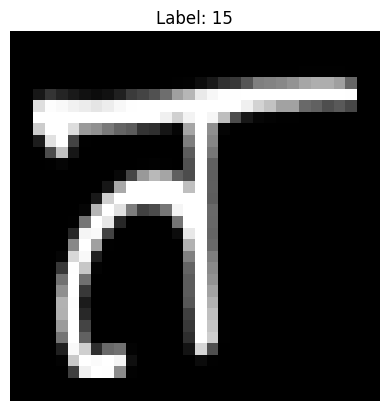

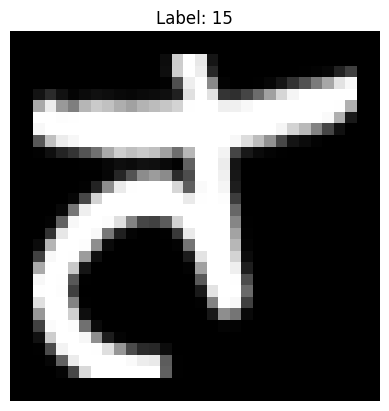

In [7]:
# Example prediction on a test pair (using a single pair from the dataset)
test_index = random.randint(0, len(val_data) - 1)
input_pair_1, input_pair_2, label, indices = val_data[test_index]  # Get a single pair and indices from the dataset

# Move the pair to the GPU if available and add a batch dimension
input_pair_1 = input_pair_1.unsqueeze(0).to(device)
input_pair_2 = input_pair_2.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output1, output2 = model(input_pair_1, input_pair_2)
    distance = torch.nn.functional.pairwise_distance(output1, output2)
    predicted_similarity = torch.sigmoid(-distance).item()

print(f'Predicted Similarity (same class): {predicted_similarity}')
print(f'Actual Label: {"Same" if label == 1 else "Different"}')

# Visualize the test pair using the indices from df
visualize(df, indices[0])  # Visualize the first image in the pair
visualize(df, indices[1])  # Visualize the second image in the pair